<a href="https://colab.research.google.com/github/i-malur/meteora-analise-de-dados-sql/blob/main/Notebook_Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [2]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [3]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [4]:
engine = create_engine('sqlite:///:memory:')

In [5]:
produtos.to_sql('produtos',engine,index=False)

205

In [6]:
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [7]:
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [8]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [9]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()

pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [10]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [16]:
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


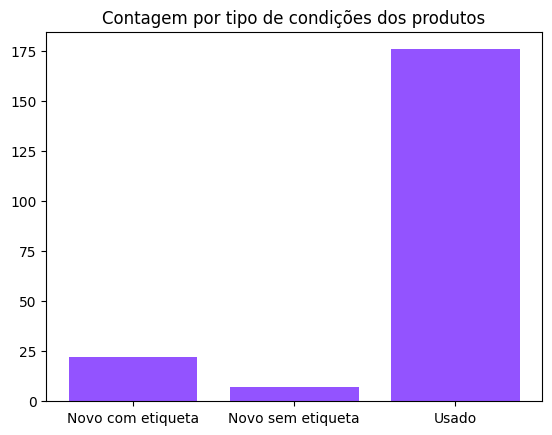

In [18]:
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353FF')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [19]:
sql_df ('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [20]:
sql_df ('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [26]:
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade ASC'''

df_prod_quant = sql_df(query)
df_prod_quant

,produto,quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


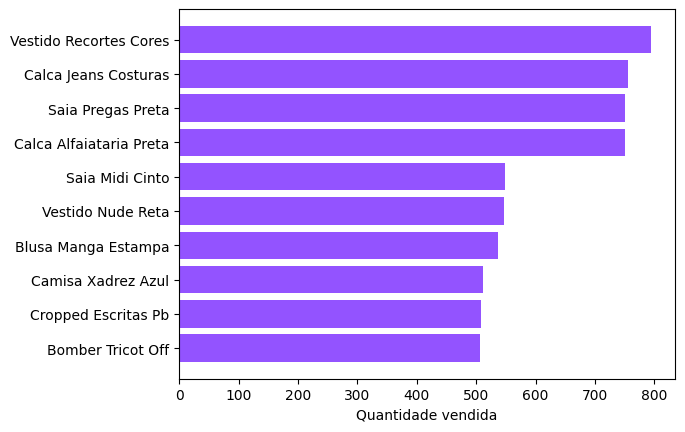

In [28]:
plt.barh(df_prod_quant['produto'][-10:], df_prod_quant['quantidade'][-10:], color='#9353FF')
plt.xlabel('Quantidade vendida')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [32]:
sql_df ('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [33]:
sql_df ('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [40]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''

sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [43]:
query = '''SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
'''

sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [46]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''

sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157


# DESAFIOS

Esse primeiro desafio vai ser constituído de duas análises, a primeira tem por objetivo calcular a receita total obtida com a venda de itens. Na tabela itens_pedidos, o valor total dos itens representa o cálculo da quantidade pelo valor unitário e pode ser considerado como a receita da venda.

Já a segunda análise visa identificar quais as 15 marcas que foram as mais pedidas por quantidades de venda. Busque mostrar essa lista em uma visualização, além de expor o nome das marcas.

## DESAFIO 1

In [29]:
df_itens_pedidos = sql_df('SELECT VALOR_TOTAL FROM ITENS_PEDIDOS')
receita = df_itens_pedidos['valor_total'].sum()
receita

45803930

In [30]:
query = '''SELECT SUM(VALOR_TOTAL) AS RECEITA
FROM ITENS_PEDIDOS;
'''
df_itens_pedidos = sql_df(query)
df_itens_pedidos

,RECEITA
0,45803930


## DESAFIO 2

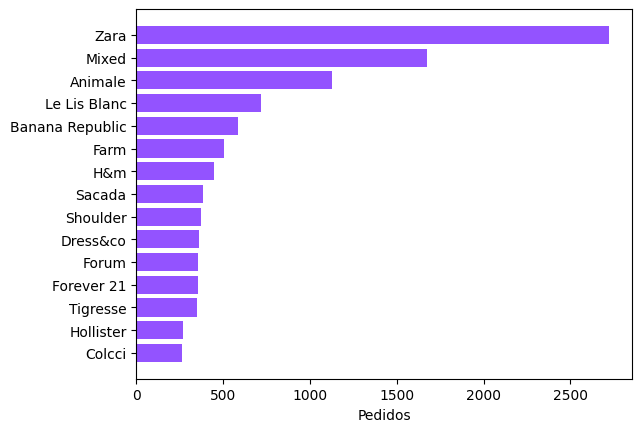

In [31]:
query = '''SELECT PRODUTOS.MARCA, COUNT (*) AS 'Pedidos'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(*) ASC;
'''
df_marcas = sql_df(query)

plt.barh(df_marcas['marca'][-15:], df_marcas['Pedidos'][-15:], color = '#9353FF')
plt.xlabel('Pedidos')
plt.show()

## DESAFIO 3

In [41]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT (PEDIDOS.PEDIDO_ID) AS TOTAL_PEDIDOS
FROM PEDIDOS, PRODUTOS
WHERE strftime('%Y', data_compra) = '2019' AND PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY TOTAL_PEDIDOS DESC
LIMIT 10;
'''
sql_df(query)

,produto,TOTAL_PEDIDOS
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


## DESAFIO 4

In [42]:
query = '''SELECT strftime('%m', data_compra) AS mes, SUM(total) AS receita
FROM pedidos
WHERE strftime('%Y', data_compra) = '2021'
GROUP BY mes;
'''
sql_df(query)

,mes,receita
0,01,2097109
1,02,1140729
2,03,51525


## DESAFIO 5

In [47]:
query = '''SELECT PRODUTOS.MARCA, COUNT(*) AS 'Produtos vendidos'
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(ITENS_PEDIDOS.PRODUTO_ID) DESC;
'''
df_marcas_sp = sql_df(query)
df_marcas_sp

,marca,Produtos vendidos
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


## DESAFIO 6
A consulta executa a seleção da coluna de PRODUTO da tabela PRODUTOS e conta a quantidade de registros. Em seguida, é realizado um JOIN entre as tabelas PRODUTOS e ITENS_PEDIDOS, ligando-as pelo campo PRODUTO_ID e outro JOIN com a tabela PEDIDOS, ligando-a pelo campo PEDIDO_ID. Aplica-se um filtro para considerar apenas os pedidos feitos no mês de dezembro, utilizando a função strftime para extrair o mês da data (%m) de compra e compará-lo com '12'.

Por fim, os dados são agrupados pelos produtos e ordenados em ordem decrescente com base na quantidade de vendas. Como retorno, temos uma tabela com a contagem de vendas de cada produto de todos os pedidos realizados em dezembro.

In [48]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(*) AS quantidade_vendas
FROM ITENS_PEDIDOS
JOIN produtos ON produtos.produto_id = ITENS_PEDIDOS.produto_id
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m',PEDIDOS.data_compra)= '12'
GROUP BY produtos.produto
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

,produto,quantidade_vendas
0,Vestido Recortes Cores,30
1,Vestido Preto Franzido,26
2,Calca Jeans Costuras,26
3,Calca Alfaiataria Preta,26
4,Camisa Xadrez Azul,25
...,...,...
196,Sneaker Monograma Bege,6
197,Casaqueto Estampa Geometrica,6
198,Regata Renda Branca,5
199,Body Estampa Coracoes,5


# Projeto com pandas

* Possíveis soluções para problemas apresentados

Construímos um código de consulta a um banco de dados com SQL, mas e se ao invés de quatro tabelas em um SGBD, nós estivéssemos lidando com DataFrames?

Digamos que os DataFrames tenham os mesmos nomes de cada uma das tabelas, vamos então ver como seria o código em Pandas que corresponderia ao resultado obtido pelas consultas que fizemos em aula no SQL.

Parte 1: selecionar coluna Condicao


```
SELECT CONDICAO FROM PRODUTOS
```
Precisamos obter o mesmo resultado da consulta, ou seja, um DataFrame. Para tal, podemos selecionar a coluna Condicao e executar a transformação da Series para DataFrame com pd.DataFrame.

```
pd.DataFrame(produtos['Condicao'])
```
Parte 2: contar as frequências


```
SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;  
```

Para aplicar uma função de agregação por contagem de frequências, podemos aplicar groupby e a agregação de contagem com size. O nome da coluna de 'Quantidade' pode ser definido com reset_index.

```
produtos.groupby('Condicao').size().reset_index(name='Quantidade')
```




Vamos novamente verificar como seriam nossas consultas caso elas fossem feitas no Pandas. Ainda vamos assumir que os DataFrames tenham os mesmos nomes de cada uma das tabelas.

Parte 1: selecionar os dados


```
sql_df ('SELECT * FROM PRODUTOS').head(3)  
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)
```

Na consulta, lemos todos os dados das tabelas produtos e itens_pedidos. Para fazer isso em Python com Pandas, basta usar o objeto específico do DataFrame.

```
produtos.head(3)  
itens_pedidos.head(3)
```

Parte 2: relacionar os produtos por quantidade


```
SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC
```

Para um código equivalente em Python com Pandas, começamos mesclando com merge os DataFrames itens_pedidos e produtos, com base na coluna produto_id. Em seguida, aplicamos a função groupby() para agrupar os dados pelo nome do produto e depois, usamos a função sum() para obter a soma da coluna quantidade para cada grupo. Por fim, para ordenar o resultado em ordem ascendente de acordo com a quantidade, usamos a função sort_values():

```
df_prod_quant = itens_pedidos.merge(produtos, on='produto_id')
df_prod_quant = df_prod_quant.groupby('produto')['quantidade'].sum().reset_index()
df_prod_quant = df_prod_quant.sort_values('quantidade', ascending=True).reset_index(drop=True)
df_prod_quant
```



Vamos explorar como realizar consultas utilizando a biblioteca Pandas. Continuamos considerando que temos DataFrames com nomes correspondentes às tabelas do nosso conjunto de dados.

Usamos a seguinte consulta:



```
SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y',data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
```

Para essa consulta, iniciamos filtrando os pedidos que ocorreram em 2020 com a função str.startswith('2020'), que filtra os pedidos que possuem a data de compra iniciando com o valor '2020'. Depois, mesclamos o DataFrame filtrado (df_filtered) com o DataFrame de vendedores com base na coluna 'vendedor_id' através da função merge.

Em seguida, usamos a função groupby, para agrupar os dados pelo nome do vendedor ('nome_vendedor') e, em seguida, calculamos a média da coluna 'total' para cada grupo. Antes de concluir, ordenamos os resultados em ordem descrescente com base na coluna 'total' usando a função sort_values(), e também resetamos os index com reset_index. Por fim, alteramos o nome da coluna 'total' para 'Valor médio por vendas', correspondendo ao resultado no SQL:

```
df_filtrado = pedidos[pedidos['data_compra'].str.startswith('2020')]
df_mesclado = df_filtrado.merge(vendedores, on='vendedor_id')
df_agrupado = df_mesclado.groupby('nome_vendedor')['total'].mean().reset_index()
df_filtro_data = df_agrupado.sort_values('total', ascending=False).reset_index(drop=True)
df_filtro_data.columns = ['nome_vendedor', 'Valor médio por vendas']
df_filtro_data
```


### contagem por estados
Vamos explorar como realizar consultas utilizando a biblioteca Pandas. Continuamos considerando que temos DataFrames com nomes correspondentes às tabelas do nosso conjunto de dados.

Usamos a seguinte consulta:
```
SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
```

Para essa consulta, começamos com a função groupby() para agrupar os dados pelo estado (coluna 'Estado') e, em seguida, aplicamos a função size() para obter a contagem de pedidos para cada estado. A função reset_index(name='Pedidos') redefine o índice do resultado agrupado e renomeia a coluna de contagem para 'Pedidos'. O resultado é um DataFrame com duas colunas: 'Estado' e 'Pedidos', onde 'Pedidos' representa a contagem de pedidos para cada estado.

Depois, usamos a função sort_values() para ordenar o DataFrame resultado em ordem decrescente com base na coluna 'Pedidos'. Ao definir ascending=False, garantimos que a ordenação seja feita em ordem decrescente. Isso nos dá o DataFrame final df_estados, correspondente ao resultado obtido na consulta:

```
df_agrupados = itens_pedidos.groupby('Estado').size().reset_index(name='Pedidos')
df_estados = df_agrupados.sort_values('Pedidos', ascending=False).reset_index(drop=True)
df_estados
```




### agrupando dados

Vamos explorar como realizar consultas utilizando a biblioteca Pandas. Continuamos considerando que temos DataFrames com nomes correspondentes às tabelas do nosso conjunto de dados.

Usamos a seguinte consulta:
```
SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y',data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
```

Iniciamos com a função merge() para combinar os DataFrames pedidos, vendedores e itens_pedidos. Depois, aplicamos a função query() para selecionar apenas os itens de pedidos com estado de São Paulo ('BR-SP'). Em seguida, utilizamos groupby() para agrupar por nome da pessoa vendedora e aplicamos size() para obter a contagem de vendas para cada pessoa vendedora. Por fim, aplicamos sort_values() para ordenar o DataFrame resultante em ordem decrescente com base na quantidade de vendas:

```
df_unido = pedidos.merge(vendedores, on='vendedor_id').merge(itens_pedidos, on='pedido_id')
df_filtrado = df_unido.query("Estado == 'BR-SP'")
df_vendedores_sp = df_filtrado.groupby('nome_vendedor').size().reset_index(name='quantidade_vendas')
df_vendedores_sp = df_vendedores_sp.sort_values('quantidade_vendas', ascending=False)
df_vendedores_sp
```

# Documentação


### SQL o que é?

SQL (Structured Query Language) é uma linguagem de programação projetada para gerenciar e manipular bancos de dados relacionais. Ela fornece um conjunto de comandos e instruções que permitem a criação, consulta, atualização e exclusão de dados em bancos de dados.

O uso dessa linguagem é essencial para trabalhar com dados armazenados em bancos de dados relacionais e é uma habilidade fundamental para pessoas desenvolvedoras, analistas de dados, administradoras de bancos de dados e outras categorias de profissões envolvidas na manipulação e análise de dados.

A linguagem SQL também é bastante utilizada em Sistemas de Gerenciamento de Bancos de Dados relacionais (SGBDs), como MySQL, PostgreSQL, SQLite, Oracle, SQL Server, entre outros. Ela oferece uma sintaxe padrão e consistente, tornando-se uma linguagem altamente portátil e interoperável entre diferentes sistemas de banco de dados.

O SQL possui comandos básicos que são fundamentais para a manipulação de dados em um banco de dados relacional, dois deles são o SELECT e o FROM.

O SELECT é usado para exibir dados de uma ou mais tabelas em um banco de dados. Ele permite especificar as colunas que você deseja selecionar.  
O FROM é usado em conjunto com o SELECT para especificar a tabela ou tabelas das quais você deseja recuperar os dados. Ele indica a origem dos dados que serão selecionados.

*  https://www.alura.com.br/artigos/o-que-e-sql
*  https://www.alura.com.br/artigos/sgbds-relacionais
*  https://www.alura.com.br/artigos/sql-comandos-basicos
*  https://www.alura.com.br/artigos/sql-consultas-com-select
*  https://www.alura.com.br/artigos/sql-clausulas-update-e-delete


###  limitando dados com SQL
Conseguimos limitar a quantidade de registros retornados pelos resultados dentro de uma consulta no SQL: a cláusula que pode executar isso é a LIMIT. Ela permite especificar a quantidade máxima de registros que você deseja receber como saída.

Por exemplo, vamos selecionar os 10 primeiros registros da tabela que relaciona produto e quantidade vendida.


```
def sql_df (query):
  with engine.connect() as connection:
    result = connection.execute(text(query))
    rows = result.fetchall()
  return pd.DataFrame(rows, columns=result.keys())

query = '''SELECT PRODUTOS.produto, SUM (ITENS_PEDIDOS.quantidade) AS 'Quantidade'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.produto
LIMIT 10;
'''
sql_df(query)
```

Podemos também usar a cláusula LIMIT em conjunto com a cláusula OFFSET para especificar um deslocamento (um ponto de partida) e retornar um conjunto específico de registros. Por exemplo, vamos selecionar do 6° ao 10° registro da tabela anterior:



```
query = '''SELECT PRODUTOS.produto, SUM (ITENS_PEDIDOS.quantidade) AS 'Quantidade'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.produto
LIMIT 5 OFFSET 5;
'''
sql_df(query)
```
Nesse caso, a consulta retorna 5 registros, começando do 6º.

Com isso, podemos usá-la quando desejamos exibir uma quantidade específica de registros ou paginar os resultados da consulta em partes menores, não necessitando fazer essa seleção com o DataFrame após a coleta da consulta.


### STRFTIME

A função strftime no SQLite é usada para formatar valores de data e hora de acordo com um padrão específico. Ela permite extrair componentes individuais de uma data e hora, como o dia, mês, ano, hora, minuto, segundo, etc., e formatá-los de acordo com suas necessidades.

A sintaxe básica da função strftime é a seguinte:


```
strftime(formato, valor)
```
O parâmetro formato especifica o padrão de formatação desejado, e o parâmetro valor é o valor da data e hora que você deseja formatar.

Com essa função, podemos extrair diferentes componentes de data e hora, por exemplo:

* Extrair o ano: '%Y';
* Extrair o mês: '%m';
* Extrair o dia: '%d'.

E para formatos de data que incluem horas como '2022-05-29 14:30:00', podemos usar os formatos de hora:

* Extrair a hora: '%H';
* Extrair o minuto: '%M';
* Extrair o segundo: '%S'.

Como um exemplo, podemos usar dessas formatações para entender a distribuição de pedidos durante os meses do ano 2019 e 2020:



```
## Selecionar dados do ano de 2019
query = '''
SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade_vendas
FROM pedidos
WHERE strftime('%Y', data_compra) = '2019'
GROUP BY mes;
'''
vendas_19 = sql_df(query)
vendas_19

## Selecionar dados do ano de 2020
query = '''
SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade_vendas
FROM pedidos
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY mes;
'''
vendas_20 = sql_df(query)
vendas_20
```


Depois de coletar os dados, podemos comparar os resultados com uma visualização.

```
import matplotlib.pyplot as plt

# Plotar o gráfico de 2019 e 2020
plt.plot(vendas_19.mes.to_numpy(), vendas_19.quantidade_vendas.to_numpy(), marker='o', linestyle='-', color='#9353FF', label = '2019')
plt.plot(vendas_20.mes.to_numpy(), vendas_20.quantidade_vendas.to_numpy(), marker='o', linestyle='-', color='#C0ED22', label = '2020')

# Definir título e eixos
plt.title('Vendas em 2019 e 2020')
plt.xlabel('Meses')
plt.ylabel('Quantidade de Vendas')

# Adicionar a legenda
plt.legend()

# Adicionar grid horizontal
plt.grid(axis='y', linestyle='--')

# Exibir a figura
plt.show()
```

RESULTADO  
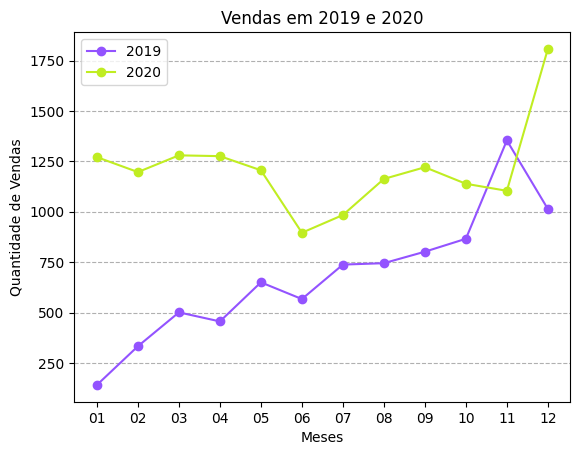


### FUNÇÕES DE AGREGAÇÃO

AVG()
É uma função que calcula a média aritmética de um conjunto de valores. Ela pode ser aplicada a colunas numéricas, como valores inteiros ou decimais. Ela ignora valores nulos durante o cálculo da média.

Um exemplo de sua utilização é o cálculo da média de produção em uma indústria. Digamos que, na coluna QUANTIDADE_PRODUZIDA da tabela PRODUCAO, existem 30 valores informando a produção diária do mês de junho na indústria. No código abaixo, a função AVG calcula a média desses 30 dias de produção.

```
query = '''
SELECT AVG(QUANTIDADE_PRODUZIDA) AS media_producao
FROM PRODUCAO;
'''
```

COUNT()
É uma função de agregação que conta o número de linhas ou valores não nulos em uma coluna ou conjunto de valores e retorna um valor inteiro. Por isso, é usada para determinar a quantidade de registros que satisfazem determinadas condições em uma consulta.

Um exemplo de sua utilização é a contagem de vendas feitas em uma loja. Suponhamos que, na tabela VENDAS_REALIZADAS, cada linha armazena uma venda realizada pelo time de vendas da loja. No código abaixo, a função COUNT calcula a quantidade de linhas e, por consequência, a quantidade de vendas realizadas.

```
query = '''
SELECT COUNT(*) AS total_vendas
FROM VENDAS_REALIZADAS;
'''
```

GROUP_CONCAT()
É uma função que concatena os valores de uma coluna em uma única string, separando-os por um delimitador especificado.

Podemos definir sua sintaxe como a seguinte:


```
GROUP_CONCAT(coluna, [delimitador])
```

Onde coluna representa a coluna da qual desejamos concatenar os valores. E delimitador define o caractere ou sequência de caracteres usado para separar os valores concatenados. Se nenhum delimitador for especificado, o SQLite usará uma vírgula (",") como delimitador padrão.


Um exemplo de sua utilização é a listagem dos nomes das pessoas na equipe de seguranças de uma empresa. Vamos supor que na coluna NOMES_SEGURANCA da tabela COLABORADORES existem os nomes das pessoas que compõem a equipe de segurança em cada linha.


```
query = '''
SELECT GROUP_CONCAT(NOMES_SEGURANCA, ', ') AS nomes_concatenados
FROM COLABORADORES;
'''
```

A função GROUP_CONCAT irá unir todos os nomes dessa coluna e retornar um texto com esses nomes separados por “,”.

MAX()
Essa função de agregação permite encontrar o valor máximo em uma coluna específica de uma tabela, retornando esse valor.

Suponha que estamos buscando o preço mais alto dos produtos de uma loja. Para isso, temos uma tabela chamada PRODUTOS e existe a coluna PRECO com valores de produtos.

Com a função MAX, encontramos o preço máximo entre todos os produtos da tabela.

```
query = '''
SELECT MAX(PRECO) AS PRECO_MAXIMO
FROM PRODUTOS;
'''
```

MIN()
Em contraste com a função MAX, a função MIN encontra o valor mínimo em uma coluna específica de uma tabela.

Como exemplo, vamos usar o mesmo da função MAX, mas dessa vez estamos buscando o valor mínimo nos preços da loja.

```
query =
SELECT MIN(PRECO)
AS PRECO_MINIMO
FROM PRODUTOS;
```

SUM() e TOTAL()
Vamos falar das duas funções, pois elas têm um objetivo muito similar, mas têm algumas diferenças em relação ao seu comportamento, em especial, em relação ao tratamento de valores nulos e ao formato do retorno da consulta.

A função SUM() é usada para calcular a soma dos valores em uma coluna numérica. Ela faz isso ignorando os valores nulos (NULL) na coluna durante o cálculo da soma. Já a função TOTAL() também é usada para calcular a soma dos valores em uma coluna numérica, mas ela trata os valores nulos (NULL) na coluna como zero (0).

Além disso, a função TOTAL() sempre irá retornar um valor de ponto flutuante. Já a SUM() pode retornar um valor inteiro ou ponto flutuante, a depender do tipo de dado agregado: se as instâncias forem de tipo inteiro, será retornado um inteiro; se forem pontos flutuantes, o retorno de SUM será ponto flutuante.

Como a função SUM e TOTAL acabam retornando o mesmo valor, podemos fazer um exemplo apenas com a SUM. Vamos considerar que desejamos descobrir o total de receita obtida em vendas. Digamos que temos uma coluna chamada VALOR na tabela VENDAS que tem a descrição das receitas geradas a cada venda.

A função SUM irá calcular a soma de todos os valores na coluna e irá retornar o resultado dessa soma.

```
query =
SELECT SUM(VALOR)
AS TOTAL_VENDAS
FROM VENDAS;
```

* https://www.sqlite.org/lang_aggfunc.html
* https://www.alura.com.br/artigos/trabalhando-funcoes-agregacao


### JOIN
Durante as aulas aprendemos a unir tabelas com a cláusula JOIN, mas existem diversos tipos de JOIN que permitem fazer consultas mais elaboradas no banco de dados.

Podemos listar quatro tipos de junções: LEFT JOIN, RIGHT JOIN, FULL JOIN e INNER JOIN. Abaixo uma imagem com quatro Diagramas de Venn, onde cada círculo (conjunto) representa uma tabela do nosso modelo relacional. Vamos conferir as diferença entre essas principais junções:
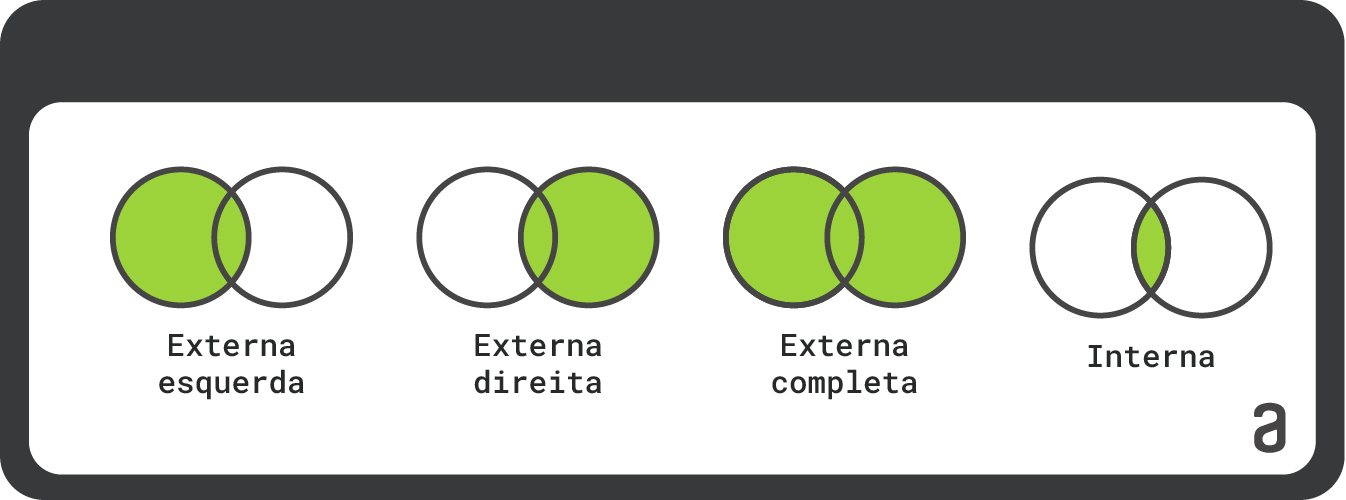


LEFT JOIN
O LEFT JOIN retorna todos os registros da tabela à esquerda na cláusula JOIN e os registros correspondentes da tabela à direita na cláusula JOIN. Seu preenchimento tem a característica do diagrama de Externa esquerda. Se não houver correspondência na tabela da direita, os valores NULL serão retornados para as colunas da tabela da direita.

A estrutura a seguir pode ser utilizada para o LEFT JOIN:
```
SELECT <CAMPOS>
FROM TABELA_A
LEFT JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO
```

RIGHT JOIN
O RIGHT JOIN é o oposto do LEFT JOIN. Ele retorna todos os registros da tabela da direita e os registros correspondentes da tabela da esquerda. Seu preenchimento tem a característica do diagrama de Externa direita. Se não houver correspondência na tabela da esquerda, os valores NULL serão retornados para as colunas da tabela da esquerda.

A estrutura a seguir pode ser utilizada para o RIGHT JOIN:
```
SELECT <CAMPOS>
FROM TABELA_A
RIGHT JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO
```

FULL JOIN
O FULL JOIN, também conhecido como FULL OUTER JOIN, retorna todos os registros de ambas as tabelas envolvidas na junção, independentemente da correspondência. Seu preenchimento tem a característica do diagrama de Externa completa. Se houver correspondência, os valores correspondentes serão retornados; caso contrário, os valores NULL serão retornados nas colunas correspondentes.

A estrutura a seguir pode ser utilizada para o FULL JOIN:
```
SELECT <CAMPOS>
FROM TABELA_A
FULL JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO
```

INNER JOIN
O INNER JOIN retorna apenas os registros que têm correspondência em ambas as tabelas envolvidas na junção. Isso significa que apenas as linhas onde as chaves correspondentes existem em ambas as tabelas serão incluídas no resultado. Seu preenchimento tem a característica do diagrama de Interna.

Para trazer essa interseção das informações entre tabelas, podemos usar o comando:

```
SELECT <CAMPOS>
FROM TABELA_A
INNER JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO
```

* https://www.alura.com.br/artigos/join-e-seus-tipos#:~:text=Existem%20cinco%20tipos%20de%20JOIN,FULL%20JOIN%20e%20CROSS%20JOIN

### integração com outros SGBDs

Durante as aulas, aprendemos a conectar o banco de dados SQLite ao Python e fizemos diversas consultas e análises com os dados contidos nele.

Além do SQLite, existem outros SGBDs que podemos fazer conexões, como o MySQL e PostgreSQL. Vamos conhecer as ferramentas disponíveis para executar essa conexão em cada um desses sistemas de gerenciamento!

MySQL  
Para se conectar ao MySQL, será preciso antes ter um servidor ativo, bem como nome de usuário, senha, host e nome do banco de dados (ou schema). Tendo esses dados, podemos usar das bibliotecas SQLAlchemy, que já conhecemos, e da mysql-connector-python, uma biblioteca Python para comunicação com servidores MySQL que você pode saber mais acessando sua [documentação](https://dev.mysql.com/doc/connector-python/en/).

Vamos mostrar uma estrutura de código que permite a conexão com as duas bibliotecas, mas sempre se certifique de ler a documentação e seguir as instruções nela descritas.

MySQL com SQLAlchemy  
Inicialmente, podemos verificar se o pacote SQLAlchemy está instalado no ambiente. Caso não esteja, podemos instalá-lo usando o pip:
```
!pip install SQLAlchemy
```
Depois, no ambiente Python, podemos estabelecer uma conexão com o banco de dados MySQL utilizando o SQLAlchemy com a construção de uma string de conexão que segue a seguinte estrutura:

```
from sqlalchemy import create_engine

# Configuração da conexão com o banco de dados
user = 'seu_usuario'
password = 'sua_senha'
host = 'localhost'
database = 'nome_do_banco_de_dados'

# Criar uma string de conexão
connection_string = f'mysql+mysqlconnector://{user}:{password}@{host}/{database}'

# Criar o engine de conexão
engine = create_engine(connection_string)

# Estabelecer a conexão
conn = engine.connect()

# A partir daqui, podemos executar consultas ou operações no banco de dados
## […]

# Fechar a conexão quando terminar
conn.close()
```
As strings 'seu_usuario', 'sua_senha' e 'nome_do_banco_de_dados' precisam ser substituídas com as informações adequadas para sua configuração.


MySQL com mysql-connector  
Essa biblioteca precisa antes ser instalada no ambiente Python para ser utilizada, portanto, verificamos inicialmente se o pacote mysql-connector-python está instalado. Caso não esteja, será preciso instalá-lo usando o pip:

```!pip install mysql-connector-python```


Em seguida, podemos estabelecer uma conexão com o banco de dados MySQL da seguinte maneira:

```
import mysql.connector

# Configuração da conexão com o banco de dados
HOST = 'localhost'
USERNAME = 'seu_usuario'
PASSWORD = 'sua_senha'
DATABASE = 'nome_do_banco_de_dados'

# Estabelecer a conexão
connection = mysql.connector.connect(
host= HOST,
user= USERNAME,
password= PASSWORD,
database= DATABASE
)

# Testar estabelecimento de conexão
if not(connection.is_connected()):
    print("Não conectado com MySQL Server")

# A partir daqui, podemos executar consultas ou operações no banco de dados
## […]

# Fechar a conexão quando terminar
conn.close()
```

PostgreSQL  
O SQLAlchemy também pode ser usado para se conectar a um banco de dados PostgreSQL, e para isso, será preciso inicialmente ter um servidor ativo, bem como nome de usuário, senha, host e nome do banco de dados.

Podemos verificar se o pacote SQLAlchemy está instalado no ambiente. Caso não esteja, podemos instalá-lo usando o pip:

```!pip install SQLAlchemy```
Depois, no ambiente Python, podemos estabelecer uma conexão com o banco de dados PostgreSQL com a construção de uma string de conexão:

```
from sqlalchemy import create_engine

# Configuração da conexão com o banco de dados
user = 'seu_usuario'
password = 'sua_senha'
host = 'localhost'
database = 'nome_do_banco_de_dados'

# Criar uma string de conexão
connection_string = f'postgresql://{user}:{password}@{host}/{database}'

# Criar o engine de conexão
engine = create_engine(connection_string)

# Estabelecer a conexão
conn = engine.connect()

# A partir daqui, podemos executar consultas ou operações no banco de dados
## […]

# Fechar a conexão quando terminar
conn.close()
```

As strings 'seu_usuario', 'sua_senha' e 'nome_do_banco_de_dados' precisam ser substituídas com as informações adequadas para sua configuração.

De modo geral, o que de fato é alterado no código das conexões entre cada SGBD é a string de conexão e, para descobrir mais informações sobre conexões desses e outros SGBDs pelo SQLAlchemy, consulte a sua [documentação](https://docs.sqlalchemy.org/en/20/core/engines.html).